## Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sns
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
import os

## Importing Data

In [2]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    'Dataset2/train/',  # Path to training data directory
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'Dataset2/test/',  # Path to testing data directory
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical')

Found 9231 images belonging to 8 classes.
Found 2457 images belonging to 8 classes.


## Classes Check

In [2]:
path = 'Dataset2/train/'

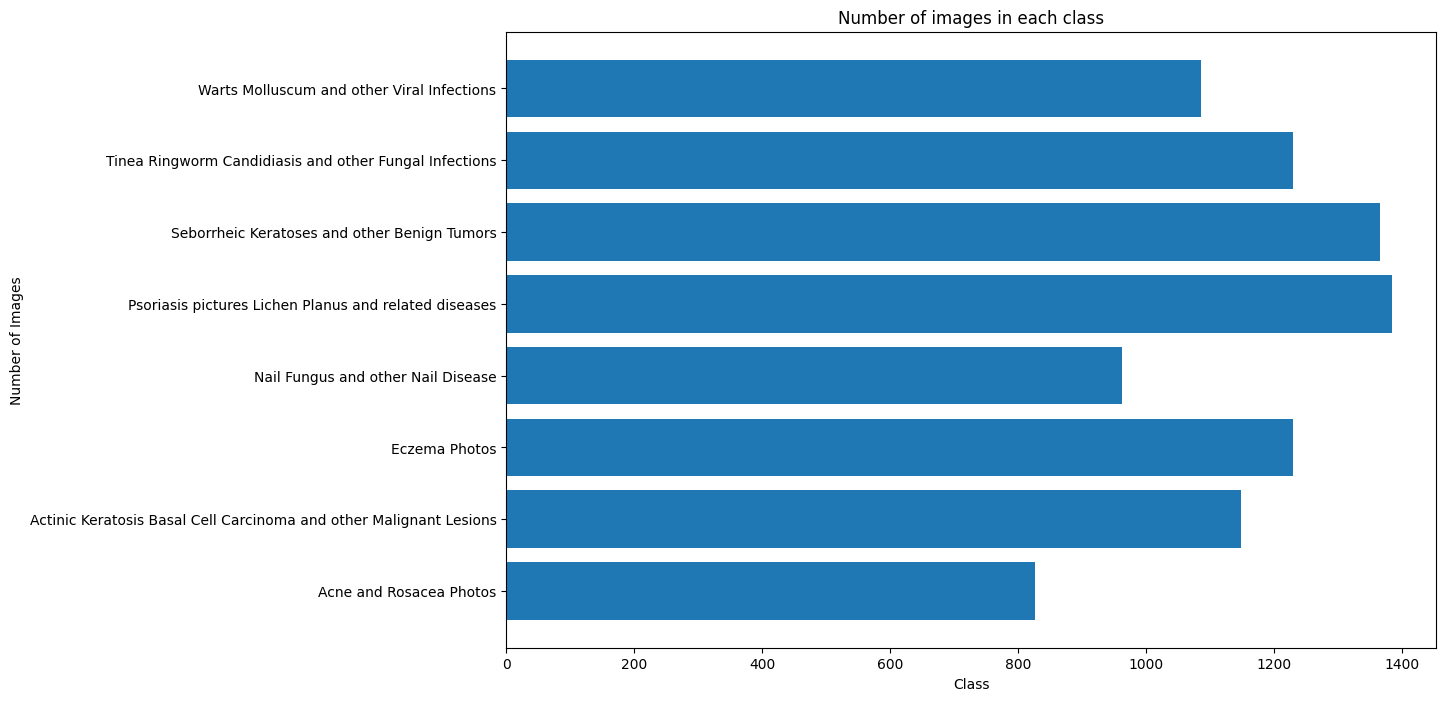

In [3]:
class_names = os.listdir(path)
num_classes = len(class_names)

img_size = (224, 224, 3)

# Number of images in each class
num_of_samples = []
for i in class_names:
    directory = path + str(i)
    num_of_samples.append(len(os.listdir(directory)))

# Plotting the number of images in each class in horizontal bar graph
plt.figure(figsize=(12, 8))
plt.barh(class_names, num_of_samples)
plt.title('Number of images in each class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

## Importing Data

In [4]:
import cv2

labels = []
images = []

for i in class_names:
    print(i, end=' --> ')
    directory = path + str(i)
    k = 0
    for j in os.listdir(directory):
        image = cv2.imread(directory + '/' + j)
        image = cv2.resize(image, img_size[0:2])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append(image)
        labels.append(i)
        k += 1
        if k == 800:
            break
    print('done')

Acne and Rosacea Photos --> done
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions --> done
Eczema Photos --> done
Nail Fungus and other Nail Disease --> done
Psoriasis pictures Lichen Planus and related diseases --> done
Seborrheic Keratoses and other Benign Tumors --> done
Tinea Ringworm Candidiasis and other Fungal Infections --> done
Warts Molluscum and other Viral Infections --> done


In [5]:
labels = np.array(labels)
images = np.array(images)

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
labels = encoder.fit_transform(labels.reshape(-1, 1)).toarray()

print('Labels shape:', labels.shape)
print('Images shape:', images.shape)

Labels shape: (6400, 8)
Images shape: (6400, 224, 224, 3)


## Splitting Data into Train and Validation

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.15, random_state=42)

## Training using Different Models

In [8]:
# from keras.applications import ResNet50

# model = ResNet50(include_top=False, weights='imagenet', input_shape=img_size)

In [9]:
# from keras.applications import VGG16

# model = VGG16(include_top=False, weights='imagenet', input_shape=img_size)

In [10]:
# from keras.applications import InceptionV3

# model = InceptionV3(include_top=False, weights='imagenet', input_shape=img_size)

In [11]:
# # EfficientNetB0

from keras.applications import EfficientNetB0

model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=img_size)

In [12]:
for layer in model.layers:
    layer.trainable = False

In [13]:
# from keras.utils.vis_utils import plot_model
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [14]:
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_val shape:', x_val.shape)
print('y_val shape:', y_val.shape)

x_train shape: (5440, 224, 224, 3)
y_train shape: (5440, 8)
x_val shape: (960, 224, 224, 3)
y_val shape: (960, 8)


In [15]:
print(y_val[0:6])

[[0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]]


In [16]:
# Saving the model with best validation accuracy
from keras.callbacks import ModelCheckpoint
# Import EarlyStopping
from keras.callbacks import EarlyStopping
checkpoint = ModelCheckpoint('best_model.h5', verbose=1, monitor='val_accuracy', save_best_only=True, mode='auto')
earlystop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='auto')
earlystop2 = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

In [17]:
def lr_schedule(epoch):
    lrate = 0.0001
    if epoch > 10:
        lrate = 0.00005
    if epoch > 15:
        lrate = 0.00001
    return lrate

In [18]:
modelSequential = Sequential()
modelSequential.add(model)
modelSequential.add(Flatten())
# modelSequential.add(Dense(512, activation='relu'))
# modelSequential.add(Dropout(0.3))
modelSequential.add(Dense(256, activation='relu'))
modelSequential.add(Dropout(0.5))
modelSequential.add(Dense(128, activation='relu'))
modelSequential.add(Dropout(0.5))
# modelSequential.add(Dense(64, activation='relu'))
# modelSequential.add(Dropout(0.3))
# modelSequential.add(Dense(32, activation='relu'))
# modelSequential.add(Dropout(0.2))
modelSequential.add(Dense(num_classes, activation='softmax'))

# Set learning rate
from keras.optimizers import Adam, SGD
modelSequential.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [19]:
modelSequential.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 256)               16056576  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 8)                 1

In [20]:
import tensorflow as tf
with tf.device('/GPU:0'):
    history = modelSequential.fit(x_train, y_train, epochs=50, batch_size=20, validation_data=(x_val, y_val), callbacks=[checkpoint, earlystop, earlystop2, tf.keras.callbacks.LearningRateScheduler(lr_schedule)])

Epoch 1/50
272/272 [==============================] - ETA: 0s - loss: 2.0171 - accuracy: 0.2915
Epoch 1: val_accuracy improved from -inf to 0.48958, saving model to best_model.h5
272/272 [==============================] - 33s 79ms/step - loss: 2.0171 - accuracy: 0.2915 - val_loss: 1.4937 - val_accuracy: 0.4896 - lr: 1.0000e-04
Epoch 2/50
272/272 [==============================] - ETA: 0s - loss: 1.7113 - accuracy: 0.3901
Epoch 2: val_accuracy improved from 0.48958 to 0.52396, saving model to best_model.h5
272/272 [==============================] - 21s 78ms/step - loss: 1.7113 - accuracy: 0.3901 - val_loss: 1.3938 - val_accuracy: 0.5240 - lr: 1.0000e-04
Epoch 3/50
272/272 [==============================] - ETA: 0s - loss: 1.5559 - accuracy: 0.4518
Epoch 3: val_accuracy improved from 0.52396 to 0.55208, saving model to best_model.h5
272/272 [==============================] - 23s 84ms/step - loss: 1.5559 - accuracy: 0.4518 - val_loss: 1.3212 - val_accuracy: 0.5521 - lr: 1.0000e-04
Epoch 4

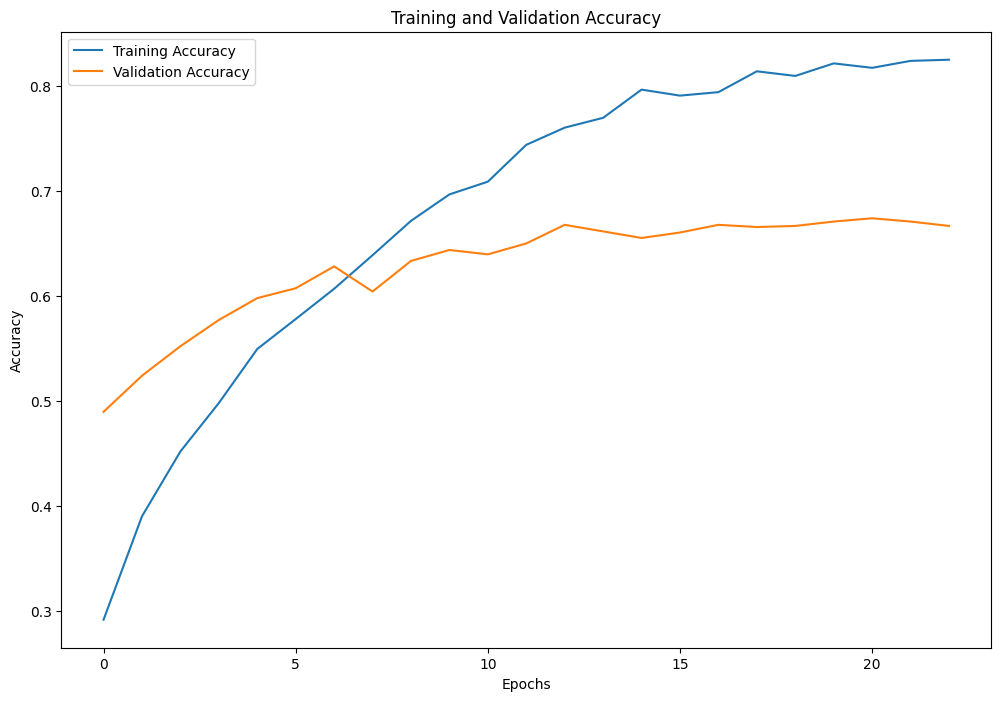

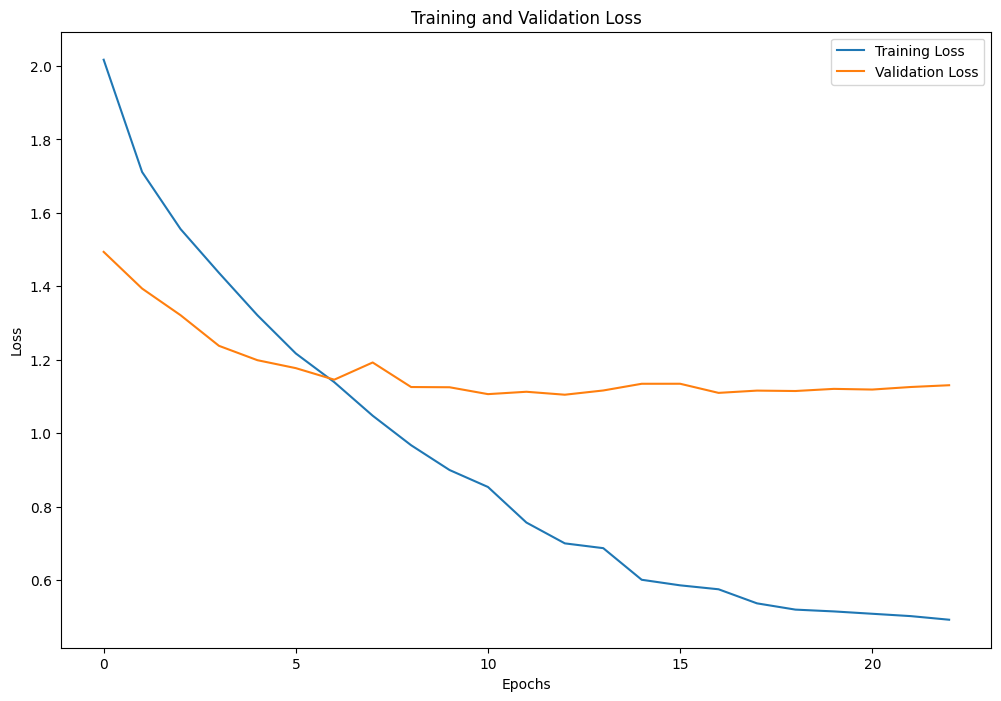

In [21]:
# Plotting the training and validation accuracy and loss
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Testing

In [51]:
# Importing the saved model
from keras.models import load_model
model = load_model('efnet4.h5')

In [52]:
# Importing the test data
path = 'Dataset2/test/'
labels = []
images = []
for i in class_names:
    print(i, end=' --> ')
    directory = path + str(i)
    k = 0
    for j in os.listdir(directory):
        image = cv2.imread(directory + '/' + j)
        image = cv2.resize(image, img_size[0:2])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append(image)
        labels.append(i)
        k += 1
        if k == 100:
            break
    print('done')

Acne and Rosacea Photos --> done
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions --> done
Eczema Photos --> done
Nail Fungus and other Nail Disease --> done
Psoriasis pictures Lichen Planus and related diseases --> done
Seborrheic Keratoses and other Benign Tumors --> done
Tinea Ringworm Candidiasis and other Fungal Infections --> done
Warts Molluscum and other Viral Infections --> done


In [53]:
# Evaluating the model on test data
np_labels = np.array(labels)
np_images = np.array(images)
one_hot_labels = encoder.transform(np_labels.reshape(-1, 1)).toarray()
print('Labels shape:', np_labels.shape)
print('Images shape:', np_images.shape)
loss, accuracy = model.evaluate(np_images, one_hot_labels, verbose=1)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

Labels shape: (800,)
Images shape: (800, 224, 224, 3)
25/25 [==============================] - 4s 84ms/step - loss: 1.1123 - accuracy: 0.6963
Test Loss: 1.1123114824295044
Test Accuracy: 0.6962500214576721


25/25 [==============================] - 2s 96ms/step


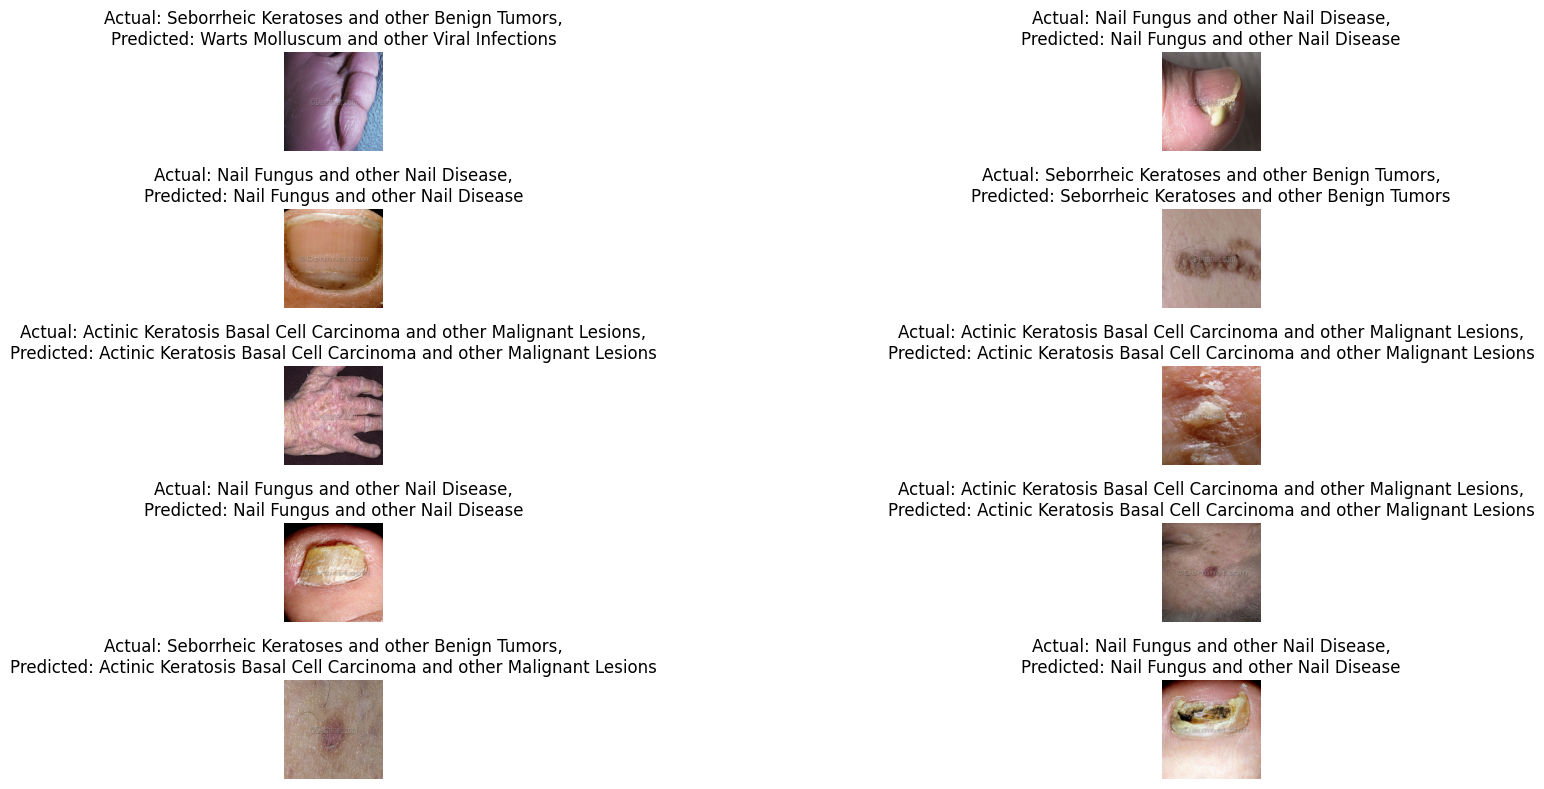

In [92]:
import matplotlib.pyplot as plt
import numpy as np
import random

plt.figure(figsize=(12, 8))

num_images_to_select = 10

random_indices = random.sample(range(len(labels)), num_images_to_select)

predictions = model.predict(np_images)

class_names = os.listdir(path)

for i, image_index in enumerate(random_indices):
    plt.subplot(5, 2, i+1)
    plt.imshow(np_images[image_index])
    plt.axis('off')
    predicted_index = np.argmax(predictions[image_index])
    true_index = np.argmax(one_hot_labels[image_index])
    plt.title('Actual: ' + class_names[true_index] + ',\nPredicted: ' + class_names[predicted_index])
plt.tight_layout()
# Margin between plots
plt.subplots_adjust(wspace=2)
plt.show()


25/25 [==============================] - 2s 85ms/step


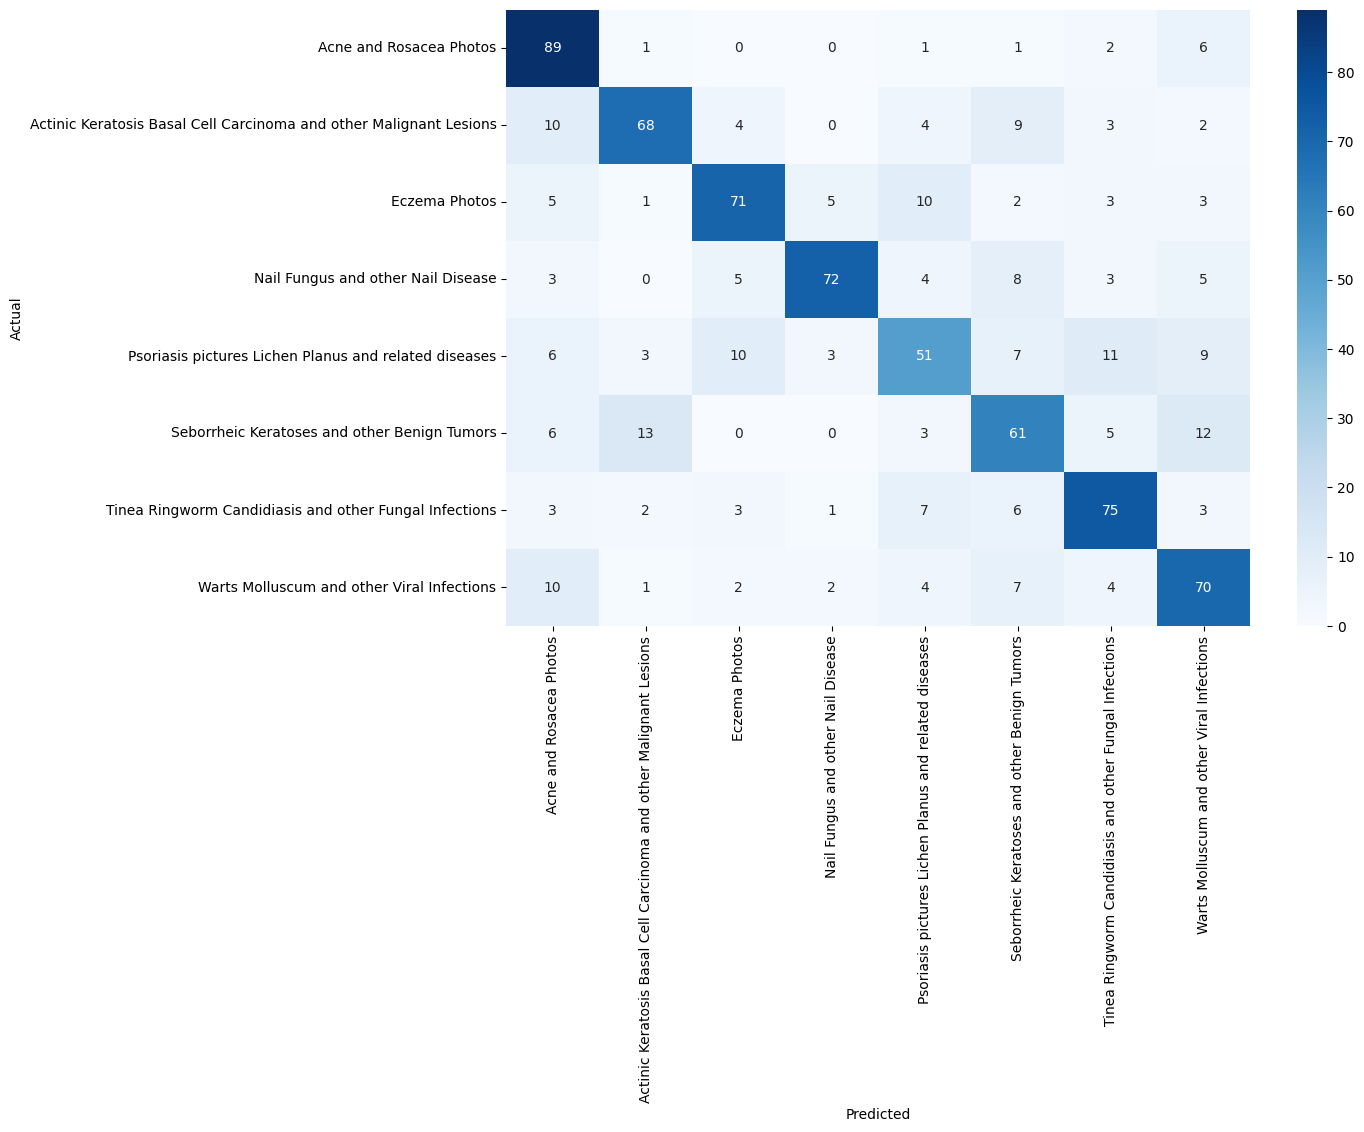

In [97]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = model.predict(np_images)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(one_hot_labels, axis=1)
class_names = os.listdir(path)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
plt.show()